In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# /content/drive/MyDrive/Copy of Copy of Brain Tumor Classifcation-20250508T163722Z-1-001.zip

In [ ]:
# base_dir = "/content/drive/MyDrive/"
# zip_path = base_dir + "Copy of Copy of Brain Tumor Classifcation-20250508T163722Z-1-001.zip"

# !unzip -q "$zip_path" -d "$base_dir"


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping



In [ ]:

# Define dataset path
train_path = "/content/drive/MyDrive/Brain Tumor Classifcation/train"
test_path = "/content/drive/MyDrive/Brain Tumor Classifcation/test"


### Verify Dataset

In [ ]:
import os

# Define dataset path
train_dir = train_path

# Get class names (subdirectories)
class_names = sorted(os.listdir(train_dir))

if not class_names:
    print("No class directories found in the train folder!")
else:
    print(f"Found {len(class_names)} classes: {class_names}")


Found 4 classes: ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']


In [ ]:
class_names

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

In [ ]:
import os
from collections import Counter

classes = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'normal']

def get_unique_extensions(directory, classes):
    extensions = []
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        for file in os.listdir(class_dir):
            ext = os.path.splitext(file)[1].lower()
            if ext:
                extensions.append(ext)
    return Counter(extensions)

train_extensions = get_unique_extensions(train_path, classes)
test_extensions = get_unique_extensions(test_path, classes)

print("Train image extensions:", train_extensions)
print("Test image extensions:", test_extensions)


Train image extensions: Counter({'.jpg': 2447})
Test image extensions: Counter({'.jpg': 621})


### Check for Corrupted Images:

In [ ]:
def find_corrupt_images(directory, classes):
    corrupt_files = []
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # This will raise an exception if the file is not a valid image
            except Exception as e:
                corrupt_files.append(file_path)
                print(f"Corrupt image: {file_path} ({e})")
    return corrupt_files

corrupt_train = find_corrupt_images(train_path, classes)
corrupt_test = find_corrupt_images(test_path, classes)

print(f"Corrupt train images: {len(corrupt_train)}")
print(f"Corrupt test images: {len(corrupt_test)}")


Corrupt image: /content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_2.jpg (cannot identify image file '/content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_2.jpg')
Corrupt image: /content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_406.jpg (cannot identify image file '/content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_406.jpg')
Corrupt image: /content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_107.jpg (cannot identify image file '/content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_107.jpg')
Corrupt image: /content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_839.jpg (cannot identify image file '/content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_839.jpg')
Corrupt image: /content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_744.jpg (cannot identify image file '/content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_744.

In [ ]:
for file_path in corrupt_train + corrupt_test:
    os.remove(file_path)
    print(f"Removed: {file_path}")


Removed: /content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_2.jpg
Removed: /content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_406.jpg
Removed: /content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_107.jpg
Removed: /content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_839.jpg
Removed: /content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_744.jpg
Removed: /content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_560.jpg
Removed: /content/drive/MyDrive/Brain Tumor Classifcation/train/glioma_tumor/G_737.jpg
Removed: /content/drive/MyDrive/Brain Tumor Classifcation/train/meningioma_tumor/M_154.jpg
Removed: /content/drive/MyDrive/Brain Tumor Classifcation/train/meningioma_tumor/M_440.jpg
Removed: /content/drive/MyDrive/Brain Tumor Classifcation/train/meningioma_tumor/M_54.jpg
Removed: /content/drive/MyDrive/Brain Tumor Classifcation/train/meningioma_tumor/M_765.jpg
Removed: /content/drive/MyDriv

In [ ]:
from PIL import Image
import os

def find_corrupt_images(directory, classes):
    corrupt_files = []
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # This will raise an exception if the file is not a valid image
            except Exception as e:
                corrupt_files.append(file_path)
                print(f"Corrupt image: {file_path} ({e})")
    return corrupt_files

corrupt_train = find_corrupt_images(train_path, classes)
corrupt_test = find_corrupt_images(test_path, classes)

print(f"Corrupt train images: {len(corrupt_train)}")
print(f"Corrupt test images: {len(corrupt_test)}")


Corrupt train images: 0
Corrupt test images: 0


### Check class distribution

In [ ]:
# Check class distribution
class_counts = {}
for class_name in classes:
    class_path = os.path.join(train_path, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path)
                 if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)

print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)




Class Distribution:
Class Name               Valid Image Count
glioma_tumor                         713
meningioma_tumor                     723
pituitary_tumor                      668
normal                               343


# Part B: (Transfer Learning).

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.15,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.15,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)


Found 2447 files belonging to 4 classes.
Using 2080 files for training.
Found 2447 files belonging to 4 classes.
Using 367 files for validation.


### Understanding train ds and val ds:

In [ ]:
for images, labels in train_ds.take(1): # Take one batch
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)


Images shape: (32, 224, 224, 3)
Labels shape: (32,)


In [ ]:
from tensorflow.keras.models import Sequential

# Data augmentation layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1, fill_mode="nearest"),
    layers.RandomZoom(0.1, fill_mode="nearest"),
], name="augmentation")



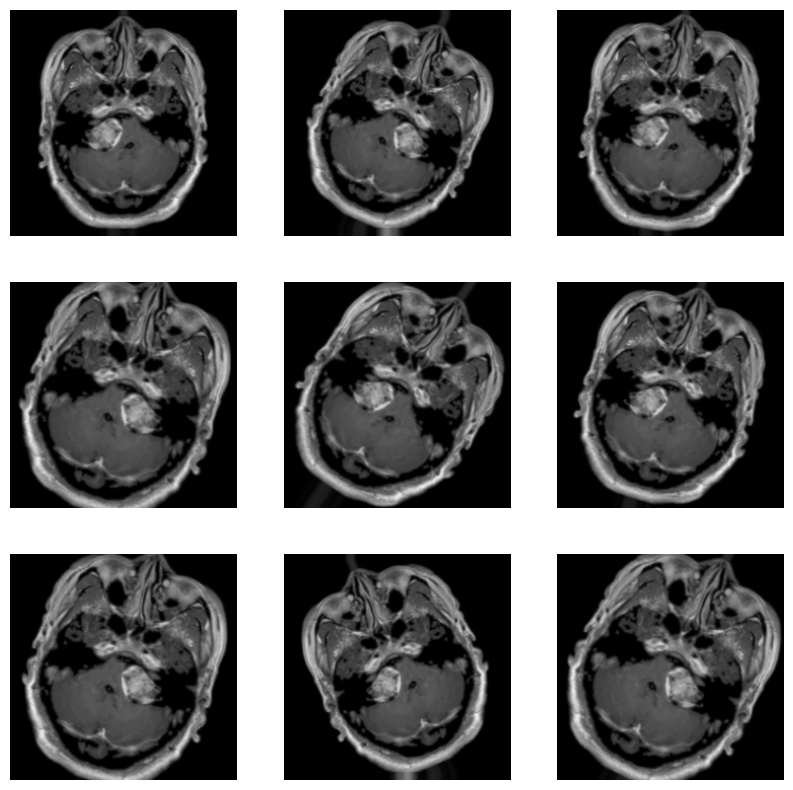

In [ ]:
# Visualize augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

## Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Set image size and classes
IMG_SIZE = (224, 224)
input_shape = (224, 224, 3)
num_classes = len(class_names)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [ ]:

from tensorflow.keras.applications import VGG16

inputs = Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# Load VGG16 without top classifier
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=x)
base_model.trainable = False  # Initially freeze all layers


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:

# Custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,979,396 (57.14 MB)

 Trainable params: 264,708 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Callbacks
from tensorflow.keras import callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:

history = None

with tf.device('/GPU:0'):
    print("Training on GPU")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stopping]
    )


Training on GPU
Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 193ms/step - accuracy: 0.4087 - loss: 1.2623 - val_accuracy: 0.6076 - val_loss: 0.9972
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.6042 - loss: 0.9419 - val_accuracy: 0.6485 - val_loss: 0.8600
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.6783 - loss: 0.7974 - val_accuracy: 0.6894 - val_loss: 0.8238
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.7259 - loss: 0.7022 - val_accuracy: 0.7030 - val_loss: 0.7356
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - accuracy: 0.7365 - loss: 0.6669 - val_accuracy: 0.6866 - val_loss: 0.8442
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - accuracy: 0.7364 - loss: 0.6756 - val_accuracy: 0.7084 - val_loss: 0.7020
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.7550 - loss: 0.6086 - val_accuracy: 0.6730 - val_loss: 0.7432
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.7412 - loss: 0

In [ ]:
test_loss, test_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {test_acc:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.8392 - loss: 0.4449
Validation Accuracy: 0.84


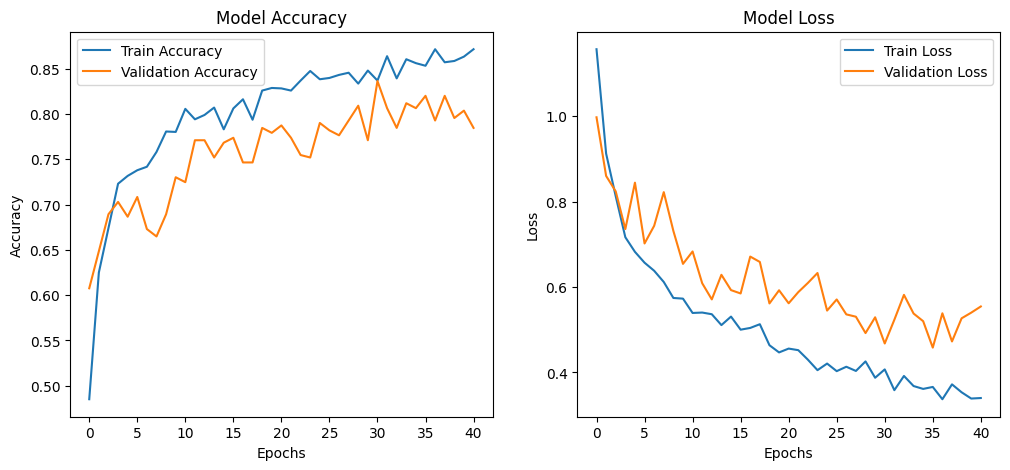

In [ ]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [ ]:
# Load test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)



Found 621 files belonging to 4 classes.


In [ ]:
# Evaluate accuracy and loss
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8340 - loss: 0.4189
Test Accuracy: 0.8213


In [ ]:
# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Print classification report
from sklearn.metrics import classification_report

print("Classification Report on Test Set:")
print(classification_report(y_true, y_pred, target_names=class_names))



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Classification Report on Test Set:
                  precision    recall  f1-score   support

    glioma_tumor       0.81      0.85      0.83       181
meningioma_tumor       0.75      0.76      0.76       183
          

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


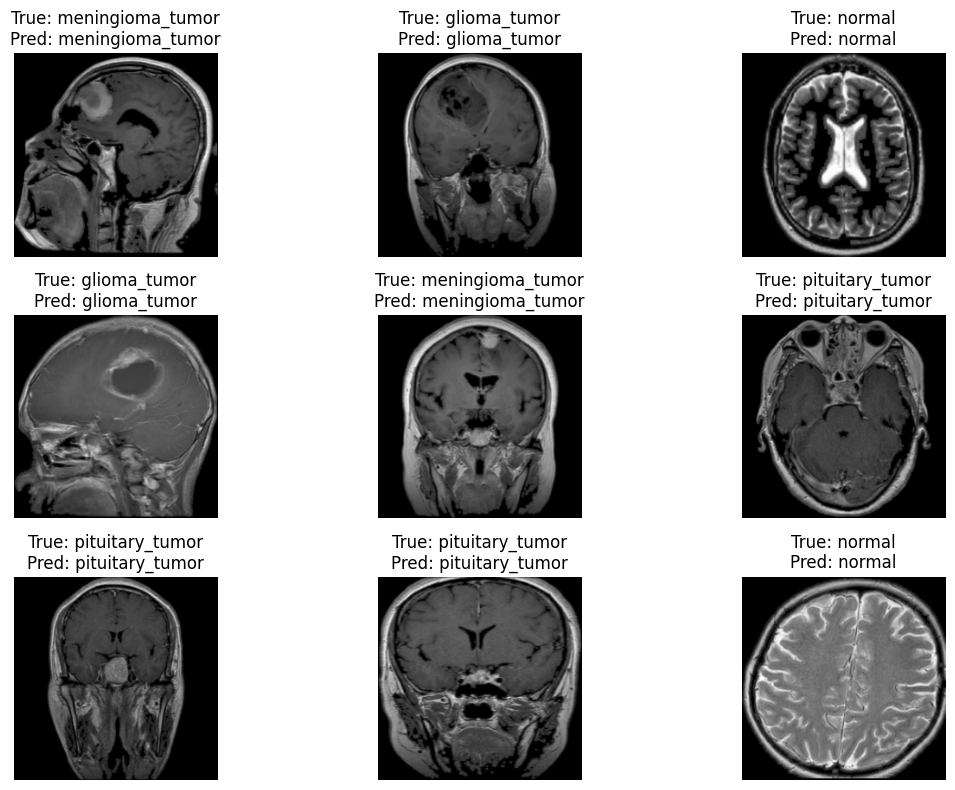

In [ ]:
for images, labels in test_ds.take(1):  # One batch
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


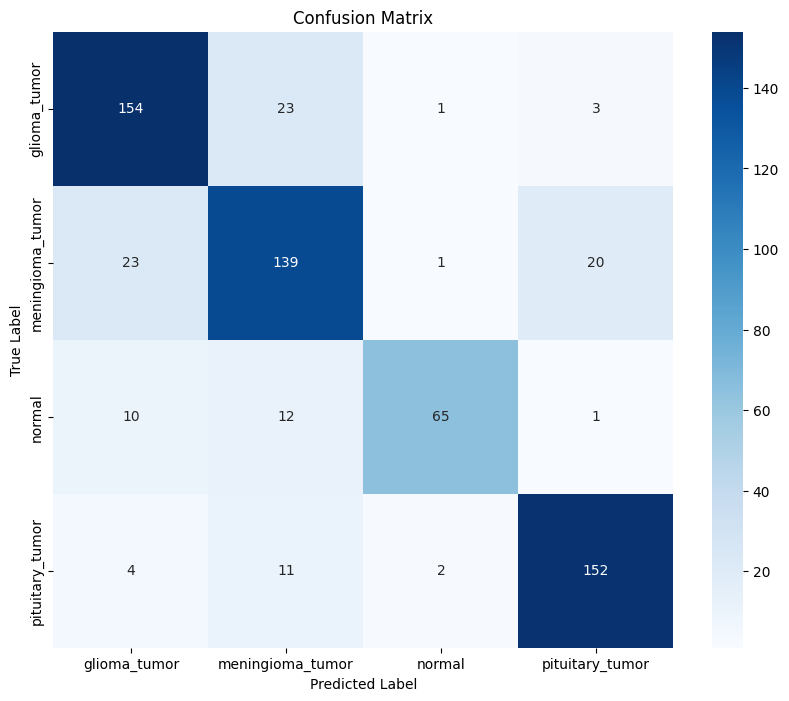

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Fine-Tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, Input, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

input_shape = (224, 224, 3)
num_classes = 4

# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


In [ ]:

# Input Layer
inputs = Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# Load VGG16 base model
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=x)
base_model.trainable = True


In [ ]:

# Unfreeze from block5_conv1 onwards
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable

# Print which layers are trainable
for layer in base_model.layers:
    print(f"{layer.name}: {'Trainable' if layer.trainable else 'Frozen'}")


input_layer_3: Frozen
sequential_1: Frozen
rescaling_1: Frozen
block1_conv1: Frozen
block1_conv2: Frozen
block1_pool: Frozen
block2_conv1: Frozen
block2_conv2: Frozen
block2_pool: Frozen
block3_conv1: Frozen
block3_conv2: Frozen
block3_conv3: Frozen
block3_pool: Frozen
block4_conv1: Frozen
block4_conv2: Frozen
block4_conv3: Frozen
block4_pool: Frozen
block5_conv1: Trainable
block5_conv2: Trainable
block5_conv3: Trainable
block5_pool: Trainable


In [ ]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:

# Add custom layers
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

# Final model
fine_model = models.Model(inputs=inputs, outputs=x)

# Compile the model
fine_model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



In [ ]:
fine_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,02

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 13,503,236 (51.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


In [ ]:
# Train the model
fine_history = fine_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - accuracy: 0.3314 - loss: 1.4564 - val_accuracy: 0.6104 - val_loss: 0.9727 - learning_rate: 1.0000e-05
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.5945 - loss: 0.9560 - val_accuracy: 0.6948 - val_loss: 0.7638 - learning_rate: 1.0000e-05
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 252ms/step - accuracy: 0.6759 - loss: 0.7853 - val_accuracy: 0.7602 - val_loss: 0.6416 - learning_rate: 1.0000e-05
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.7426 - loss: 0.6876 - val_accuracy: 0.7493 - val_loss: 0.5977 - learning_rate: 1.0000e-05
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step - accuracy: 0.7768 - loss: 0.5957 - val_accuracy: 0.7766 - val_loss: 0.5392 - learning_rate: 1.0000e-05
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step - accuracy: 0.7993 - loss: 0.5370 - val_accuracy: 0.8038 - val_loss: 0.5253 - learning_rate: 1.0000e-05
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - acc

In [ ]:
# Evaluate accuracy and loss
test_loss, test_accuracy = fine_model.evaluate(val_ds)
print(f"Validation Accuracy: {test_accuracy:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.8612 - loss: 0.4736
Validation Accuracy: 0.8910


In [ ]:
# Evaluate accuracy and loss
test_loss, test_accuracy = fine_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9048 - loss: 0.2963
Test Accuracy: 0.9098


In [ ]:
# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = fine_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Print classification report
from sklearn.metrics import classification_report

print("Classification Report on Test Set:")
print(classification_report(y_true, y_pred, target_names=class_names))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Classification Report on Test Set:
                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.92      0.92       181
meningioma_tumor       0.91      0.82      0.86       183
          

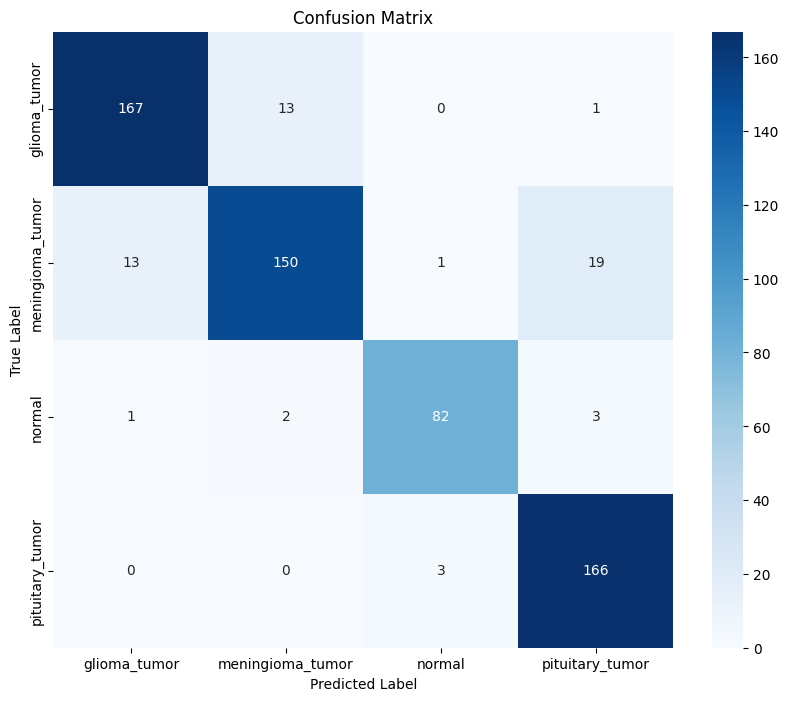

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


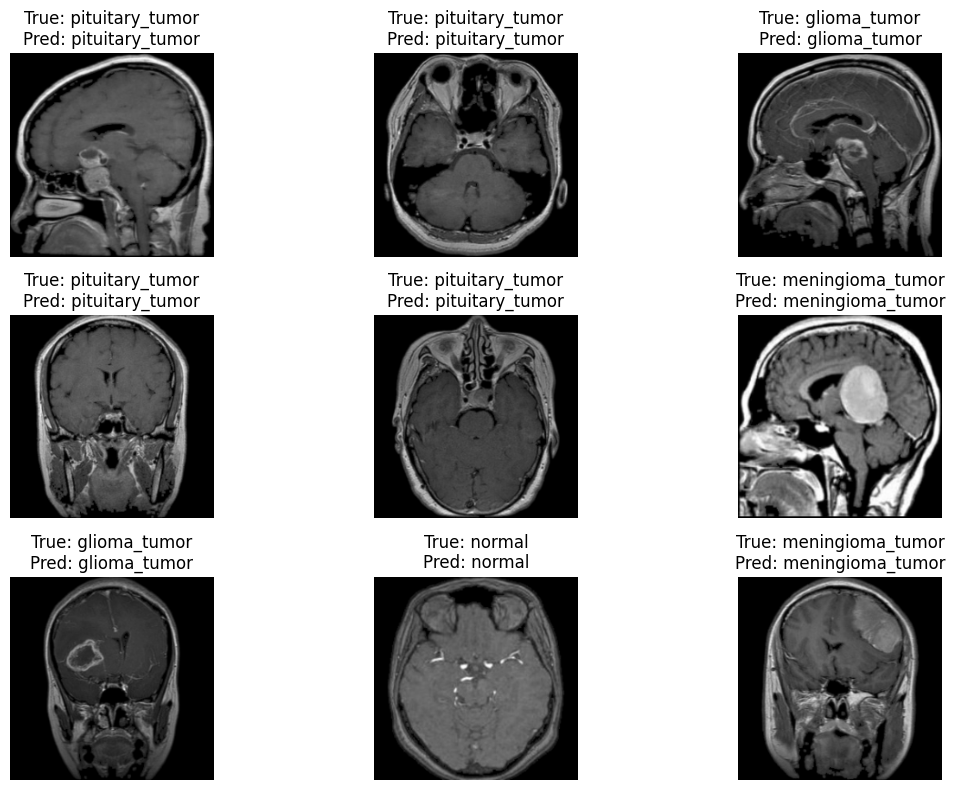

In [ ]:
for images, labels in test_ds.take(1):  # One batch
    predictions = fine_model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Comparison: Pretrained VGG16 vs Fine-Tuned VGG16

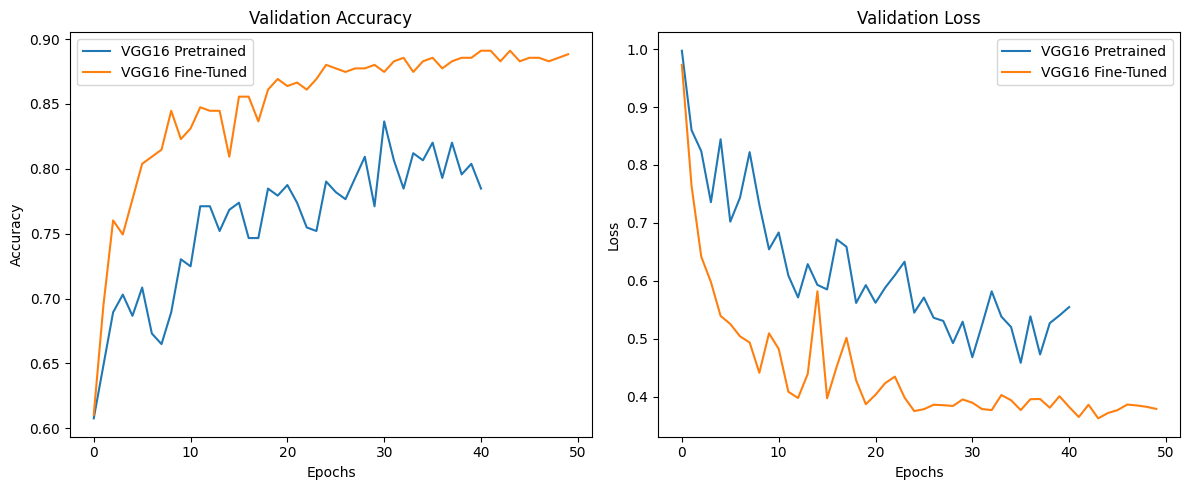

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='VGG16 Pretrained')
plt.plot(fine_history.history['val_accuracy'], label='VGG16 Fine-Tuned')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='VGG16 Pretrained')
plt.plot(fine_history.history['val_loss'], label='VGG16 Fine-Tuned')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate frozen VGG16 model
test_loss_vgg, test_accuracy_vgg = model.evaluate(test_ds)
print(f"VGG16 (Frozen) - Test Accuracy: {test_accuracy_vgg:.4f}, Test Loss: {test_loss_vgg:.4f}")

# Evaluate fine-tuned VGG16 model
test_loss_vgg_ft, test_accuracy_vgg_ft = fine_model.evaluate(test_ds)
print(f"VGG16 (Fine-Tuned) - Test Accuracy: {test_accuracy_vgg_ft:.4f}, Test Loss: {test_loss_vgg_ft:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.8136 - loss: 0.4759
VGG16 (Frozen) - Test Accuracy: 0.8213, Test Loss: 0.4894
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.9003 - loss: 0.3382
VGG16 (Fine-Tuned) - Test Accuracy: 0.9098, Test Loss: 0.3092


# Model Evaluation and Prediction

**Training from Scratch (Part A):**
1. Baseline: Test Accuracy: 0.8293, Test Loss: 1.3165, Macro F1: 0.83
2. Deeper (Adam): Test Accuracy: 0.8551, Test Loss: 1.2873, Macro F1: 0.86
3. Deeper (SGD): Test Accuracy: 0.8502, Test Loss: 1.3504, Macro F1: 0.85

**Transfer Learning (Part B):**

1. VGG16 (Frozen): Test Accuracy: 0.8213, Test Loss: 0.4894
2. VGG16 (Fine-Tuned): Test Accuracy: **0.9098**, Test Loss: 0.3092

- Training Time: The frozen VGG16 model trained for ~12 minutes and The fine-tuned model took ~15.4 minutes


### **Does Transfer Learning Outperform Training from Scratch?**
Yes, VGG16 Fine-Tuned outperforms all models:

- Highest Accuracy: 0.9098 vs. 0.8551 (Deeper Adam, best scratch model).
- Lowest Loss: 0.3092 vs. 1.2873 for scratch models.


---


Why might by Better: The frozen VGG16 (0.8213 accuracy) underperforms compared to Deeper models, highlighting the necessity of fine-tuning for optimal results. Scratch models are limited by overfitting and dataset size (2,447 training images), making transfer learning the preferred approach.

## Hardware Acceleration

 All models were trained on a T4 GPU in Google Colab